In [6]:
import numpy as np
from numpy import random
from numpy.random import choice

def normpdf(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma)**2) / (np.sqrt(2 * np.pi) * sigma)

def multinomial_resampling(weights):
    N = len(weights)
    indices = np.arange(N)
    resampled_indices = choice(indices, size=N, replace=True, p=weights)
    return resampled_indices

def tractable_smc_fredholm(N, f_1, Y, epsilon):
    # N is the number of particles 
    # f_1 is an N-dimensional initialization distribution
    # Y is an array of sample observations
    # epsilon is the standard deviation of the Gaussian smoothing kernel

    # Number of observations
    n = len(Y)

    # Initialization
    X_particles = np.zeros((n, N))
    Y_particles = np.zeros((n, N))
    weights = np.zeros((n, N))

    # at time n=1
    # Initial distribution is given as the input 
    X_particles[0, :] = f_1
    # Uniform weights are given as the input
    weights[0, :] = np.ones(N) / N 
    Y_particles[0, :] = Y

    # at time n>1
    for i in range(1, n):
        # Markov Chain step
        X_particles[i, :] = X_particles[i-1, :] + epsilon * np.random.standard_normal(N)

        weights[i, :] = weights[i-1, :]
        # draw samples from Y 
        hN = np.zeros(N) 
        for j in range(0, N):
            hN[j] = np.mean(weights[i, :] * normpdf(Y[j], X_particles[i, :], 0.045))

        # calculate potentials
        potential = np.zeros(N)
        g = normpdf(Y, X_particles[i, :], 0.045)
        potential[hN != 0] = g[hN != 0] / hN[hN != 0]
        potential[hN == 0] = 0
        # update and normalize weights 
        weights[i, :] = weights[i, :] * g

        weights[i, :] = weights[i, :] / np.sum(weights[i, :])

        # Resampling particles with updated weights
        Y_particles[i, :] = choice(Y, N, replace=False)
        
        # Effective Sample Size (ESS)
        ESS = 1 / np.sum(weights[i, :]**2)
        
        # Resampling
        if ESS < N / 2:
            indices = multinomial_resampling(weights[i, :])
            X_particles[i, :] = X_particles[i, indices]
            weights[i, :] = np.ones(N) / N
        else:
            X_particles[i, :] = X_particles[i-1, :]
            weights[i, :] = weights[i-1, :]

    return X_particles

 



In [7]:
target_data= tractable_smc_fredholm(1000, random.standard_normal(1000), 0.5 + np.sqrt(0.088) * random.standard_normal(1000), 0.01)

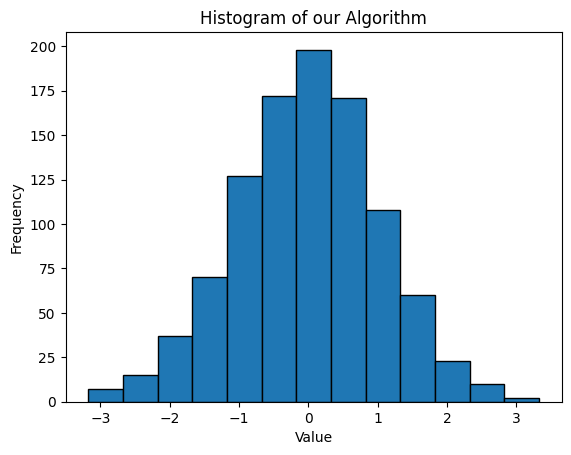

In [8]:
particle_1 = target_data[0,:]
import matplotlib.pyplot as plt
import numpy as np

# Sample data as a NumPy array
data = particle_1

# Define bin size
bin_size = 0.5

# Compute bin edges
bins = np.arange(min(data), max(data) + bin_size, bin_size)

# Plot histogram
plt.hist(data, bins=bins, edgecolor='black')

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of our Algorithm')

# Show the plot
plt.show()